# Exploratory Data Analysis

- [Accéder aux bases](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2022/)
- [Accéder à la documentation](https://www.data.gouv.fr/fr/datasets/r/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a)

# Objectifs : prédire la gravité d'un accident

La gravité d'un accident est codée par la variable `grav`, présente (uniquement) dans la base _usagers_, qui peut prendre les valeurs suivantes :
- 1 : indemne ;
- 2 : tué ;
- 3 : blessé hospitalisé ;
- 4 : blessé léger.

On charge dans un premier temps tous les packages nécessaires.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Sur data.gouv, quatre bases de données sont publiées annuellement. Elles concernent : les usages, les véhicules, les lieux et les caractéristiques. Nous chargeons ci-dessous les quatre bases de 2022 (les plus récentes).

In [3]:
df_usagers_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8", sep=";")
df_vehicules_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0", sep=";")
df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")
df_caracs_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7", sep=";")

/tmp/ipykernel_23617/411945651.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")


In [4]:
from data_cleaning import *

# Usagers

- 126 662 observations et 16 colonnes
- Quelques NaN, uniquement pour la variable `an_nais` (année de naissance)

La base est composée de variables essentiellement catégorielles.

In [7]:
df_usagers_22 = clean_df_usagers(df_usagers_22)

In [ ]:
df_usagers_22.head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1


In [ ]:
df_usagers_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126662 entries, 0 to 126661
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      126662 non-null  int64  
 1   id_usager    126662 non-null  object 
 2   id_vehicule  126662 non-null  object 
 3   num_veh      126662 non-null  object 
 4   place        126662 non-null  int64  
 5   catu         126662 non-null  int64  
 6   grav         126662 non-null  int64  
 7   sexe         126662 non-null  int64  
 8   an_nais      123788 non-null  float64
 9   trajet       126662 non-null  int64  
 10  secu1        126662 non-null  int64  
 11  secu2        126662 non-null  int64  
 12  secu3        126662 non-null  int64  
 13  locp         126662 non-null  int64  
 14  actp         126662 non-null  object 
 15  etatp        126662 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 15.5+ MB


## Statistiques descriptives

Etudions un peu plus en détails la variable `grav`.

In [ ]:
df_usagers_22["grav"].value_counts()

 1    53630
 2    49981
 3    19260
 4     3550
-1      241
Name: grav, dtype: int64

Conclusion : il y a majoritairement des victimes indemmes ou légèrement blessées.

On note toutefois la présence (étrange, puisque non renseignée dans la documentation) de la valeur `-1`. Explorons cette bizarrerie en affichant le début du tableau avec des observations filtrées pour ne conserver que celles dont `grav==-1`.

In [ ]:
df_usagers_22[df_usagers_22["grav"]==-1].head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
92,202200000042,1 099 608,813 891,B01,1,1,-1,-1,NaN,-1,-1,-1,-1,0,0,-1
106,202200000048,1 099 595,813 880,C01,1,1,-1,-1,NaN,-1,-1,-1,-1,-1,-1,-1
1069,202200000466,1 098 604,813 136,B01,1,1,-1,-1,NaN,-1,-1,-1,-1,-1,-1,-1
1218,202200000530,1 098 453,813 034,A01,1,1,-1,-1,NaN,-1,-1,-1,-1,-1,-1,-1
2238,202200000966,1 097 379,812 214,B01,1,1,-1,-1,NaN,-1,-1,-1,-1,-1,-1,-1


On note qu'on a souvent également `sexe==-1`, et qu'on a également beaucoup de valeurs `-1` pour les autres variables. Dans la documentation, pour ces autres variables, une valeur de `-1` signifie "non renseigné". Il est probable que ces `-1` pour les variables `grav` et `sexe` correspondent également à des valeurs non renseignées !

Nous allons donc en profiter pour remplacer les `-1` par des `NaN`.

In [ ]:
df_usagers_22.replace(-1, np.NaN, inplace=True)
df_usagers_22

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1 099 700,813 952,A01,1.0,1,3.0,1.0,2008.0,5.0,2.0,8.0,NaN,NaN,NaN,NaN
1,202200000001,1 099 701,813 953,B01,1.0,1,1.0,1.0,1948.0,5.0,1.0,8.0,NaN,NaN,NaN,NaN
2,202200000002,1 099 698,813 950,B01,1.0,1,2.0,1.0,1988.0,9.0,1.0,0.0,NaN,0.0,0.0,NaN
3,202200000002,1 099 699,813 951,A01,1.0,1,1.0,1.0,1970.0,4.0,1.0,0.0,NaN,0.0,0.0,NaN
4,202200000003,1 099 696,813 948,A01,1.0,1,1.0,1.0,2002.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126657,202200055301,968 230,715 631,A01,1.0,1,1.0,2.0,2002.0,5.0,1.0,NaN,NaN,0.0,0.0,NaN
126658,202200055301,968 231,715 631,A01,8.0,2,3.0,2.0,2004.0,5.0,1.0,NaN,NaN,0.0,0.0,NaN
126659,202200055301,968 232,715 632,B01,1.0,1,2.0,2.0,1953.0,5.0,1.0,NaN,NaN,0.0,0.0,NaN
126660,202200055302,968 228,715 629,A01,1.0,1,3.0,1.0,1992.0,1.0,2.0,6.0,NaN,NaN,NaN,NaN


Regardons à présent les statistiques descriptives de la base usagers en ventilant selon les modalités des autres variables catégorielles.

In [ ]:
df_usagers_22.groupby("grav").mean()

,Num_Acc,place,catu,sexe,an_nais,trajet,secu1,secu2,secu3,locp,etatp
grav,,,,,,,,,,,
-1,2.022000e+11,0.962656,1.004149,-0.991701,2005.000000,-0.995851,-0.029046,-0.962656,-0.962656,-0.933610,-1.000000
1,2.022000e+11,1.427149,1.168749,1.176151,1982.195721,3.066735,1.612400,0.475778,-0.980254,-0.446224,-0.984710
2,2.022000e+11,2.684225,1.444225,1.217746,1974.955775,3.768732,1.917746,0.456620,-0.761127,0.345915,-0.669859
3,2.022000e+11,2.605659,1.438733,1.292316,1981.571288,3.442991,1.961838,1.057009,-0.700363,0.226532,-0.706334
4,2.022000e+11,2.563934,1.454753,1.365439,1986.013885,3.165203,2.059983,1.194934,-0.941818,-0.030992,-0.721734


**Catégorie d'usager** - On constate ci-dessous que les piétons sont globalement plus gravement atteints que les conducteurs et passagers (ces derniers étant eux-mêmes légèrement plus gravement atteints que les conducteurs).

In [ ]:
df_usagers_22.groupby("catu")[["grav"]].mean()

,grav
catu,
conducteur,1.718829
passager,1.817765
pieton,2.349467


**Sexe** - Les femmes sont touchées de manière légèrement plus grave que les hommes, mais cela ne semble pas significatif. 

In [ ]:
df_usagers_22.groupby("sexe")[["grav"]].mean()

,grav
sexe,
femme,1.813946
homme,1.793771


Remarqué un peu par hasard : il semblerait que la différence entre les conducteurs et passagers ne soit significative que chez les femmes.

In [ ]:
df_usagers_22.groupby(["sexe", "catu"])[["grav"]].mean()

grav
sexe  catu                
femme conducteur  1.685784
      passager    1.863451
      pieton      2.329261
homme conducteur  1.756461
      passager    1.774495
      pieton      2.369371

In [43]:
df_usagers_22.groupby(["sexe", "catu"])[["grav"]].mean()

grav
sexe  catu                
femme conducteur  1.685784
      passager    1.863451
      pieton      2.329261
homme conducteur  1.756461
      passager    1.774495
      pieton      2.369371

In [50]:
df_usagers_22.groupby("trajet", dropna=False)[["grav"]].mean().sort_values("grav", ascending=False)

,grav
trajet,
promenade-loisirs,1.913952
domicile-ecole,1.887235
courses-achats,1.876650
domicile-travail,1.777607
autre,1.764627
NaN,1.720498
utilisation pro,1.436242


<AxesSubplot:xlabel='trajet', ylabel='count'>

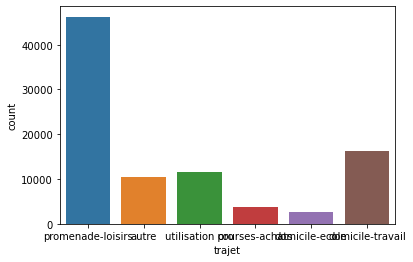

In [51]:
sns.countplot(data=df_usagers_22, x="trajet")

<AxesSubplot:xlabel='catr', ylabel='count'>

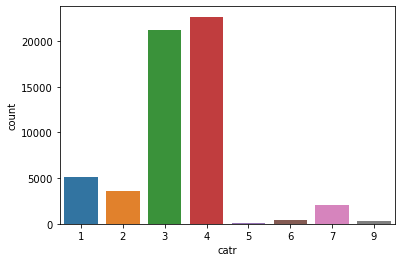

In [6]:
sns.countplot(data=df_lieux_22, x="catr")

# Véhicules

In [9]:
df_vehicules_22 = clean_df_vehicules(df_vehicules_22)

In [10]:
df_vehicules_22

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202200000001,813 952,A01,1.0,2.0,0.0,2.0,1.0,9.0,1.0,NaN
1,202200000001,813 953,B01,1.0,7.0,0.0,2.0,2.0,1.0,1.0,NaN
2,202200000002,813 950,B01,2.0,7.0,0.0,2.0,8.0,15.0,1.0,NaN
3,202200000002,813 951,A01,2.0,10.0,0.0,2.0,1.0,1.0,1.0,NaN
4,202200000003,813 948,A01,2.0,7.0,0.0,2.0,1.0,2.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
94488,202200055300,715 633,A01,2.0,7.0,2.0,0.0,1.0,1.0,1.0,NaN
94489,202200055301,715 631,A01,2.0,7.0,0.0,0.0,8.0,19.0,1.0,NaN
94490,202200055301,715 632,B01,2.0,7.0,0.0,2.0,1.0,1.0,1.0,NaN
94491,202200055302,715 629,A01,1.0,33.0,0.0,2.0,1.0,1.0,1.0,NaN


# Lieux

In [11]:
df_lieux_22 = clean_df_lieux(df_lieux_22)

In [12]:
df_lieux_22

,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202200000001,voie communale,TEIL(vieille route du),0,NaN,chausée bidirectionnelle,2,NaN,1,(1),(1),1,NaN,-1,normale,NaN,chaussée,50.0
1,202200000002,voie communale,NaN,0,NaN,chausée bidirectionnelle,2,NaN,1,(1),(1),1,NaN,-1,normale,NaN,chaussée,50.0
2,202200000003,route departementale,ROND POINT DE BREZILLET,0,NaN,NaN,2,NaN,1,0,0,1,NaN,-1,normale,carrefour aménagé,chaussée,50.0
3,202200000004,voie communale,QUATORZE JUILLET (RUE DU),0,NaN,chaussée unidirectionnelle,1,NaN,2,(1),(1),1,NaN,4,normale,NaN,chaussée,30.0
4,202200000005,route departementale,ROUTE DE JEAN MOULIN-RN 538,0,NaN,chausée bidirectionnelle,2,NaN,1,8,0,1,NaN,-1,normale,NaN,chaussée,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55297,202200055298,route departementale,71,-1,NaN,chausée bidirectionnelle,2,NaN,2,(1),(1),1,NaN,-1,normale,NaN,autre,80.0
55298,202200055299,route departementale,973,-1,NaN,chausée bidirectionnelle,2,NaN,1,29,0,2,NaN,-1,normale,NaN,acottement,80.0
55299,202200055300,route departementale,22,0,D,chausée bidirectionnelle,2,NaN,1,39,553,2,NaN,-1,verglacée,NaN,acottement,80.0
55300,202200055301,route departementale,18,-1,D,chausée bidirectionnelle,2,NaN,1,30,125,1,NaN,-1,normale,NaN,chaussée,80.0


# Caracs

In [13]:
df_caracs_22 = clean_df_caracs(df_caracs_22)

In [14]:
df_caracs_22

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,heure
0,202200000001,19,10,2022,16:15,1.0,26,26198,agglo,3.0,1.0,3.0,TEIL(vieille route du),44.559420,4.725720,16:15:00
1,202200000002,20,10,2022,08:34,1.0,25,25204,agglo,3.0,1.0,3.0,Miranda,46.925810,6.346200,08:34:00
2,202200000003,20,10,2022,17:15,1.0,22,22360,agglo,6.0,1.0,2.0,ROND POINT DE BREZILLET,48.493162,-2.760439,17:15:00
3,202200000004,20,10,2022,18:00,1.0,16,16102,agglo,3.0,8.0,6.0,LOHMEYER (RUE),45.692652,-0.326290,18:00:00
4,202200000005,19,10,2022,11:45,1.0,13,13103,hors agglo,1.0,1.0,2.0,ROUTE DE JEAN MOULIN-RN 538,43.675579,5.092703,11:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55297,202200055298,1,1,2022,03:50,3.0,2B,2B293,hors agglo,1.0,1.0,6.0,D71,42.310165,9.478583,03:50:00
55298,202200055299,1,1,2022,07:20,3.0,84,84074,hors agglo,1.0,1.0,6.0,D973,43.753164,5.224476,07:20:00
55299,202200055300,1,1,2022,04:27,3.0,74,74001,hors agglo,1.0,9.0,6.0,D22,46.282532,6.732806,04:27:00
55300,202200055301,1,1,2022,08:40,1.0,81,81099,hors agglo,3.0,1.0,3.0,Chemin Toulze,43.927265,1.915637,08:40:00
